In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/")

Mounted at /content/drive


INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


                       y
ds                      
2012-08-25 00:00:00    8
2012-08-25 01:00:00    2
2012-08-25 02:00:00    6
2012-08-25 03:00:00    2
2012-08-25 04:00:00    2
...                  ...
2014-09-25 19:00:00  868
2014-09-25 20:00:00  732
2014-09-25 21:00:00  702
2014-09-25 22:00:00  580
2014-09-25 23:00:00  534

[18288 rows x 1 columns]
              y
ds             
2012-01-09  112
2012-01-10  248
2012-01-11  304
2012-01-12  210
2012-01-13    0
DatetimeIndex(['2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12',
               '2012-01-13', '2012-01-14', '2012-01-15', '2012-01-16',
               '2012-01-17', '2012-01-18',
               ...
               '2014-11-30', '2014-12-01', '2014-12-02', '2014-12-03',
               '2014-12-04', '2014-12-05', '2014-12-06', '2014-12-07',
               '2014-12-08', '2014-12-09'],
              dtype='datetime64[ns]', name='ds', length=1066, freq='D')
              y         ds
ds                        
2012-01-09  112 2012-

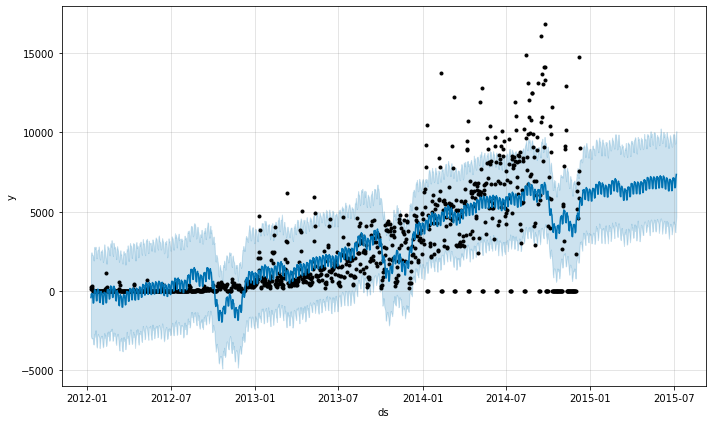

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


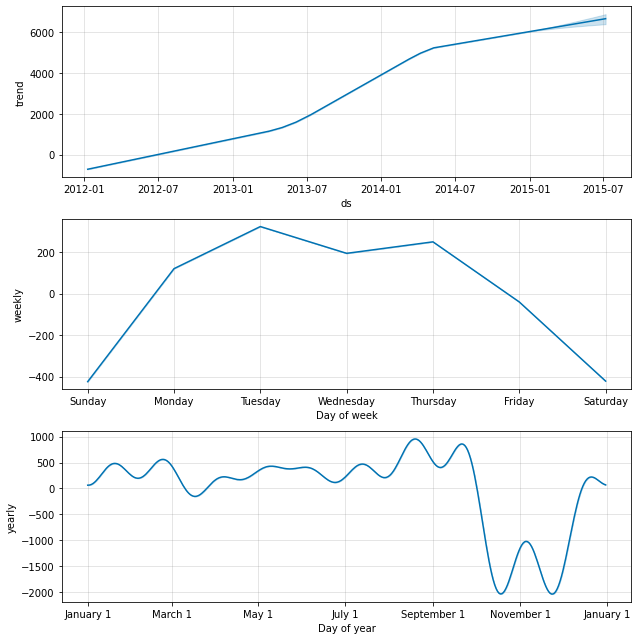

In [10]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

# 使用Prophet预测jetrail未来7个月（210天）的count 从2012年8月25日开始到2014年9月25日结束
# 读入数据集
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/jettrail_train.csv',index_col=0)
# 修改列名 Datetime => ds, Count => y
df.rename(columns={'Datetime':'ds', 'Count':'y'}, inplace=True)
df.ds = pd.to_datetime(df.ds)
df = df.set_index('ds')
print(df)
df = df.resample("D").sum()
print(df.head())
print(df.index)
df['ds'] = df.index
print(df.head())
# 拟合模型
model = Prophet()
model.fit(df)

# 构建待预测日期数据框，periods = 210 代表除历史数据的日期外再往后推210天即7个月
future = model.make_future_dataframe(periods=210)
#print(future.tail())

# 预测数据集
forecast = model.predict(future)
#print(forecast.columns)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# 展示预测结果
model.plot(forecast)
plt.show()

# 预测的成分分析绘图，展示预测中的趋势、周效应和年度效应
model.plot_components(forecast)
print(forecast.columns)



Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


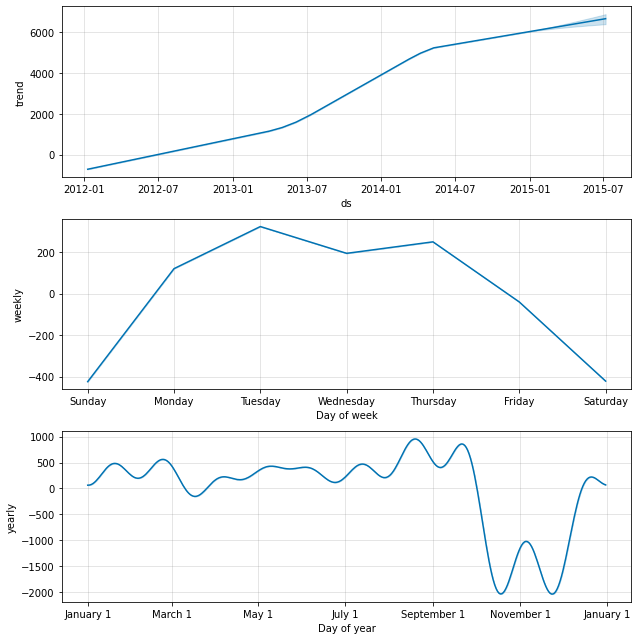

In [11]:
# 预测的成分分析绘图，展示预测中的趋势、周效应和年度效应
model.plot_components(forecast)
print(forecast.columns)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds   cap
0    2012-01-09  1244
1    2012-01-10  1244
2    2012-01-11  1244
3    2012-01-12  1244
4    2012-01-13  1244
...         ...   ...
1271 2015-07-03  1244
1272 2015-07-04  1244
1273 2015-07-05  1244
1274 2015-07-06  1244
1275 2015-07-07  1244

[1276 rows x 2 columns]


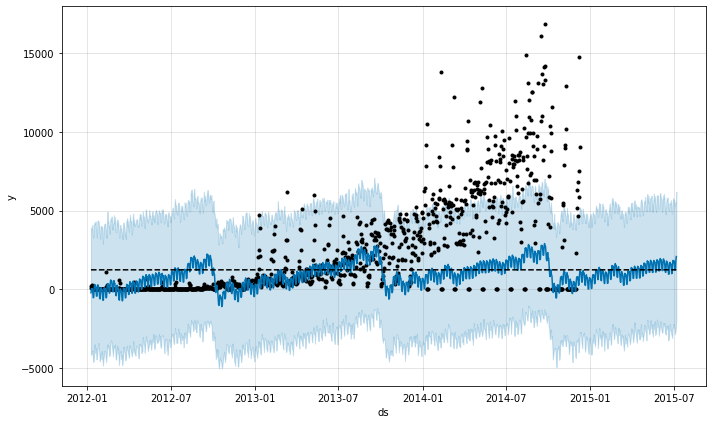

In [12]:
# 饱和增长
df['cap'] = 1500
m = Prophet(growth='logistic')
m.fit(df)

# 预测未来7个月的数据
future = m.make_future_dataframe(periods=210)
# 将未来的承载能力设定得和历史数据一样（历史最高值1244）
future['cap'] = 1244
fcst = m.predict(future)
fig = m.plot(fcst)
print(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


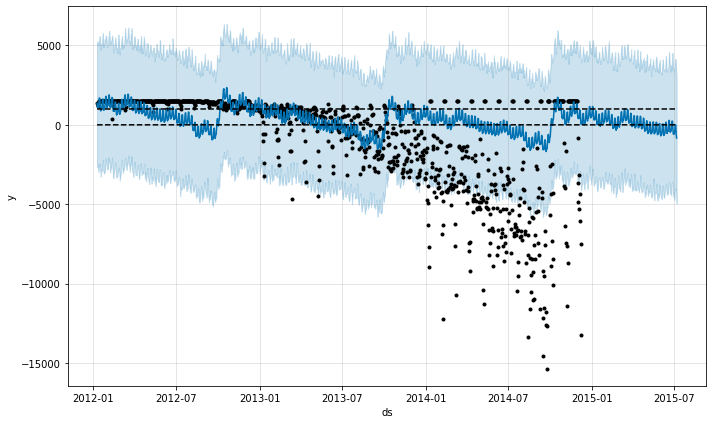

In [13]:
# 预测饱和减少
df['y'] = 1500 - df['y']
df['cap'] = 1000
# 设置下限
df['floor'] = 1.5
future['cap'] = 1000
future['floor'] = 1.5
m = Prophet(growth='logistic')
m.fit(df)
fcst = m.predict(future)
fig = m.plot(fcst)

In [15]:
Prophet?

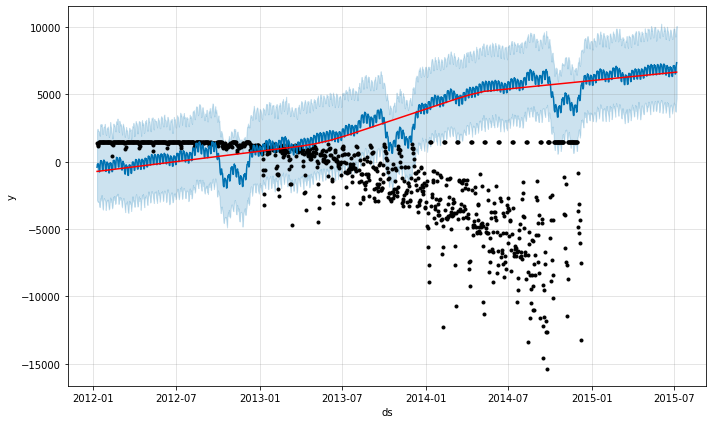

In [16]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
# plt.gca()获得当前的Axes对象ax
# 获取显著的突变点的位置
a = add_changepoints_to_plot(fig.gca(), m, forecast)
print(m)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


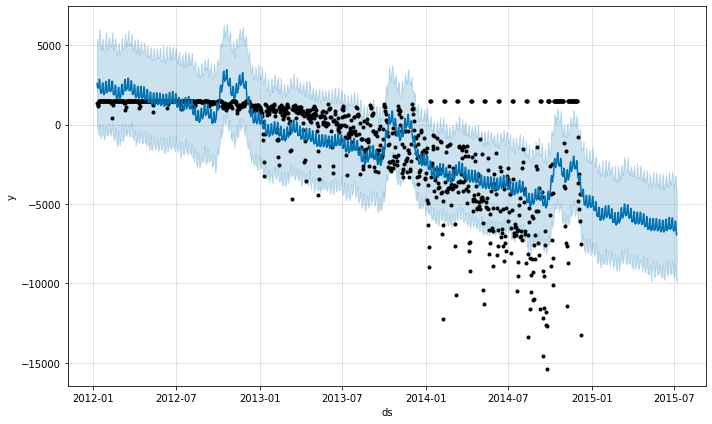

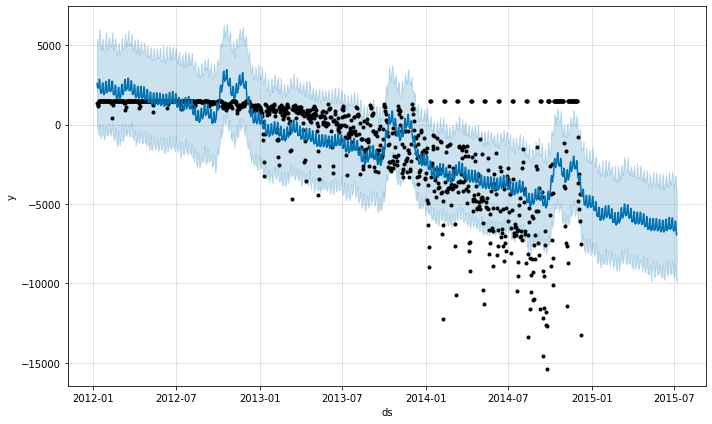

In [17]:
# 指定突变点的位置
m = Prophet(changepoints=['2014-04-10'])
m.fit(df)
future = m.make_future_dataframe(periods=210)
forecast = m.predict(future)
m.plot(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


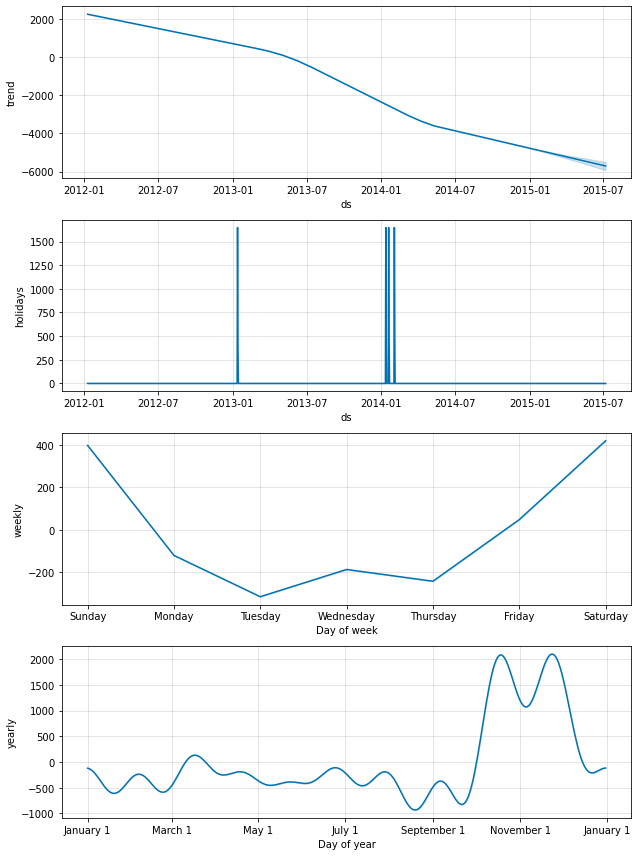

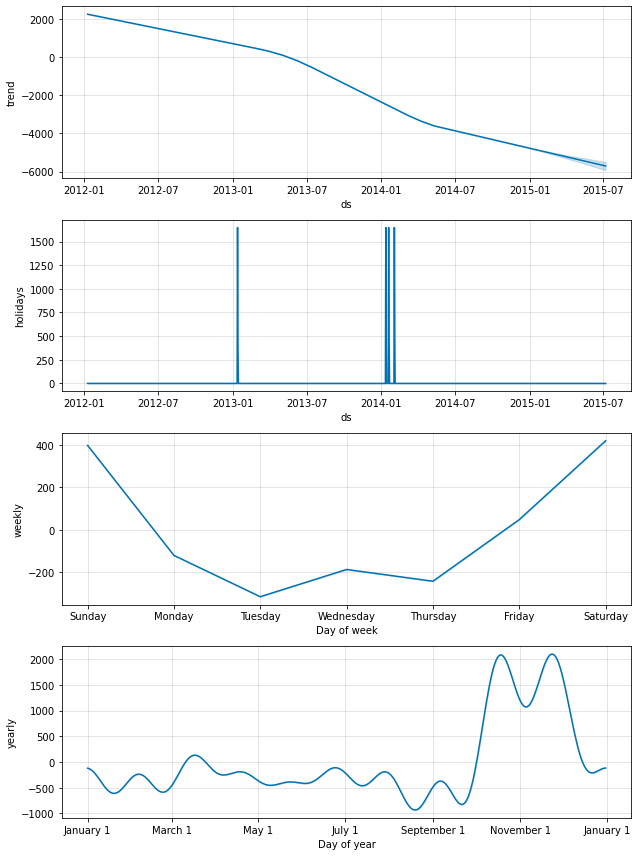

In [18]:
# 对节假日建模
# 将节日看成是一个正态分布，把活动期间当做波峰，lower_window 以及upper_window 的窗口作为扩散
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime([          '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02']),
  'lower_window': 0,
  'upper_window': 1,
})
#holidays = pd.concat((playoffs))
m = Prophet(holidays=playoffs)
m.fit(df)
future = m.make_future_dataframe(periods=210)
forecast = m.predict(future)
#print(forecast)
# 通过 forecast 数据框，展示节假日效应
forecast[(forecast['playoff']).abs() > 0][['ds', 'playoff']][-10:]
# 可以使用 plot_forecast_component（从fbprophet.plot导入）来画出独立的节假日的成分

from fbprophet.plot import plot_forecast_component
#m.plot_forecast_component(forecast, 'superbowl')
m.plot_components(forecast, 'playoff')